# 😀 Sentiment Analysis 🙁

In [2]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
import emoji
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
import contractions
import swifter
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset:
- [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [3]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"], index_col=False)
df.drop(columns=["ids", "date", "flag", "user"], inplace=True)
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


Sentiment labeling in the dataset:
- 0 = negative
- 4 = positive

In [4]:
df.sentiment = LabelEncoder().fit_transform(df.sentiment)
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


Sentiment labeling now:
- 0 = negative
- 1 = positive

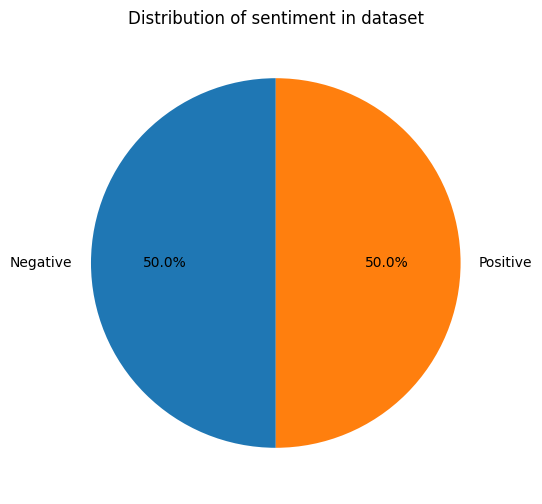

In [5]:
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

# Preprocessing

In [6]:
class TextPreprocessor:
    def __init__(self):
        # Initialize the word lemmatizer and the emojis dictionary
        self.word_lemmatizer = WordNetLemmatizer()
        self.emojis = {
            ':)': 'smile',
             ':-)': 'smile',
             ';d': 'wink',
             ':-E': 'vampire',
             ':(': 'sad',

            ':-(': 'sad',
             ':-<': 'sad',
             ':P': 'raspberry',
             ':O': 'surprised',

            ':-@': 'shocked',
             ':@': 'shocked',
            ':-$': 'confused',
             ':\\': 'annoyed',

            ':#': 'mute',
             ':X': 'mute',
             ':^)': 'smile',
             ':-&': 'confused',
             '$_$': 'greedy',

            '@@': 'eyeroll',
             ':-!': 'confused',
             ':-D': 'smile',
             ':-0': 'yell',
             'O.o': 'confused',

            '<(-_-)>': 'robot',
             'd[-_-]b': 'dj',
             ":'-)": 'sad smile',
             ';)': 'wink',
             ';D': 'wink',

            ';-)': 'wink',
             'O:-)': 'angel',
            'O*-)': 'angel',
            '(:-D': 'gossip',
             '=^.^=': 'cat',
             ':D':'smile',
        }

    def clean_text(self, text):
        """Clean text from unwanted elements (urls, mentions, hashtags,
        non-alphabetical characters) and handle CamelCase hashtags."""

        def split_camel_case(hashtag):
            """Split CamelCase hashtags into separate words."""
            return re.sub(r'(?<!^)(?=[A-Z])', ' ', hashtag)
        text = text.strip()
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', lambda m: split_camel_case(m.group(1)), text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        return text

    def filter_non_english_words(self, text):
        """Remove all words that contain non-English characters."""
        pattern = r'\b(?:[a-zA-Z]+|[a-zA-Z_]+)\b'
        filtered = re.findall(pattern, text)
        return ' '.join(filtered)

    def reduce_len_text(self, text):
        """Reduce text repetitive letters """
        repeat_regexp = re.compile(r'(.)\1{2,}')
        return repeat_regexp.sub(r'\1', text)

    def lemmatize_text(self, text):
        """ Lemmatize text """
        return ' '.join(self.word_lemmatizer.lemmatize(word) for word in text.split())

    def handle_emojies(self, text):
        """Replace emojis with text"""
        text = emoji.demojize(text, delimiters=(" ", " "))
        for e, meaning in self.emojis.items():
            text = text.replace(e, meaning)
        return text

    def preprocess(self, text):
        """
        Preprocess using all the previous functions
        """
        replace_emojie = self.handle_emojies(text)
        cleaned_text = self.clean_text(replace_emojie)
        no_repetition = self.reduce_len_text(cleaned_text)
        lemmatized_text = self.lemmatize_text(no_repetition)
        clean = self.filter_non_english_words(lemmatized_text)
        return clean

pre = TextPreprocessor()
# test the preprocessor
word = "2024 saw incumbents ♥ struggle globally due to economic woes and conflicts. Populists gained ground, deepening political divides. #Elections2024 #GlobalTrends https://t.co/8M00R0k8EA "
print(word)
print(pre.preprocess(word))



2024 saw incumbents ♥ struggle globally due to economic woes and conflicts. Populists gained ground, deepening political divides. #Elections2024 #GlobalTrends https://t.co/8M00R0k8EA 
saw incumbent heartsuit struggle globally due to economic woe and conflict populist gained ground deepening political divide election globaltrends


In [7]:
df['cleaned_text'] = df['text'].swifter.apply(pre.preprocess)
df = df[df['cleaned_text'] != '']
df

Pandas Apply:   0%|          | 0/1600000 [00:00<?, ?it/s]

,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aw that s a bummer you shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many time for the ball managed to save...
3,0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...
...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb com very cool to hear old walt interview
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of al time tupac a...


In [9]:
print(f"Number of empty strings in cleaned_text: {(df['cleaned_text'] == '').sum()}")


Number of empty strings in cleaned_text: 0


In [13]:
conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\dell\anaconda3\envs\Myenv

  added / updated specs:
    - cudatoolkit=10.0
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libavif_api-1.1.1         |       h57928b3_2           9 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          48 KB  conda-forge
    aom-3.9.1                  |       he0c23c2_0         1.9 MB  conda-forge
    ca-certificates-2024.12.31 |       haa95532_0         129 KB
    cudatoolkit-10.0.130       |                0       250.0 MB
    dav1d-1.2.1                |       h2bbff1b_0         672 KB
    filelock-3.13.1            |  py313haa95532_0          25 KB
    freetype-2.12.1            |       hdaf720e_2         498 KB  conda-forge
    giflib-5.2.2               |       h7e

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /pytorch/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:Star

In [14]:
pip install -U sentence-transformers

  Using cached sentence_transformers-3.4.0-py3-none-any.whl.metadata (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
embeddings = model.encode(df['cleaned_text'], device=model.device)

In [12]:
# vect = TfidfVectorizer(stop_words='english', max_features=100000)
# X= vect.fit_transform(df['cleaned_text'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

In [15]:
# # df_vect = pd.DataFrame.sparse.from_spmatrix(X, columns=vect.get_feature_names_out())
# df_vect = pd.DataFrame.sparse.from_spmatrix(X, columns=[vect.get_feature_names_out()])

# df_vect
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1277048, 100000)
Shape of X_test: (319263, 100000)
Shape of y_train: (1277048,)
Shape of y_test: (319263,)


In [75]:
def score_model(model):
    """Score the model using cross validation"""
    y_pred = model.predict(X_test)
    print("classification report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    print("f1_score: ", f1_score(y_test, model.predict(X_test)))
    if hasattr(model, 'predict_proba'):
        print("predict proba:\n", model.predict_proba(X_test))
        return model.predict_proba(X_test)


# Logistic Regression

In [76]:
# Train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_prob = score_model(lr)

classification report:
               precision    recall  f1-score   support

    Negative       0.79      0.75      0.77    159053
    Positive       0.76      0.80      0.78    160210

    accuracy                           0.78    319263
   macro avg       0.78      0.78      0.78    319263
weighted avg       0.78      0.78      0.78    319263

f1_score:  0.7811460755060075
predict proba:
 [[0.23575148 0.76424852]
 [0.03634818 0.96365182]
 [0.62375526 0.37624474]
 ...
 [0.31053456 0.68946544]
 [0.40000253 0.59999747]
 [0.28482618 0.71517382]]


# LinearSVC

In [77]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
lsvc_prob = score_model(lsvc)
f1_score(y_test, lsvc.predict(X_test))

classification report:
               precision    recall  f1-score   support

    Negative       0.78      0.75      0.76    159053
    Positive       0.76      0.79      0.77    160210

    accuracy                           0.77    319263
   macro avg       0.77      0.77      0.77    319263
weighted avg       0.77      0.77      0.77    319263

f1_score:  0.774563963269526


0.774563963269526

# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prob = score_model(rf)

In [ ]:

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Mean Squared Error: {mse}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [42]:
def classify_text(probabilities, threshold=0.5):
    """Classify text using the model"""
    labels = []
    for p in probabilities:
        neg  = p[0]
        pos = p[1]
        if abs(neg - pos) <= threshold:
            labels.append(-1)
        else:
            labels.append(0 if pos < neg else 1)

    return labels


labeling = classify_text(lr_prob)

In [73]:
t = "sky is beautiful"
cleaned_text = pre.preprocess(t)

# Vectorize the text
X_new = vect.transform([cleaned_text])

# Predict sentiment
probs = lr.predict_proba(X_new)
sentiment = classify_text(probs, 0.5)
print(f"Sentiment: {sentiment}")

Sentiment: [1]
